## Libraries

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data

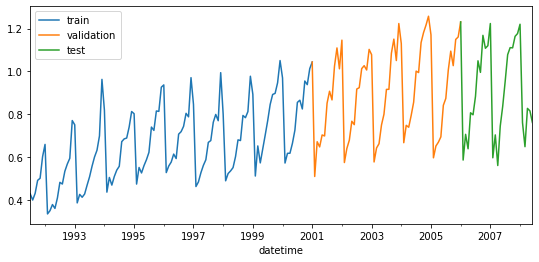

In [13]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 24
data_train = data.loc[: '2001-01-01']
data_val = data.loc['2001-01-01' : '2006-01-01']
data_test  = data.loc['2006-01-01':]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_val.plot(ax=ax, label='validation')
data_test.plot(ax=ax, label='test')
ax.legend();

## Grid search with time series cross-validation

In [17]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Placeholder, the value will be overwritten
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.loc[:'2006-01-01'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 12,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(data_train),
                        return_best = True,
                        verbose     = False
                    )

Number of models compared: 18


loop lags_grid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.28s/it]

Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10] 
  params: {'max_depth': 5, 'n_estimators': 50}



In [20]:
print(results_grid.to_markdown(tablefmt="github", index=False))

| lags                            | params                                 |    metric |   max_depth |   n_estimators |
|---------------------------------|----------------------------------------|-----------|-------------|----------------|
| [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 5, 'n_estimators': 50}   | 0.0334486 |           5 |             50 |
| [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 10, 'n_estimators': 50}  | 0.0392212 |          10 |             50 |
| [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 15, 'n_estimators': 100} | 0.0392658 |          15 |            100 |
| [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 5, 'n_estimators': 100}  | 0.0395258 |           5 |            100 |
| [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 10, 'n_estimators': 100} | 0.0402408 |          10 |            100 |
| [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 15, 'n_estimators': 50}  | 0.0407645 |          15 |             50 |
| [ 1  2  3 20]                   | {'ma

In [19]:
forecaster

<class 'skforecast.ForecasterAutoreg.ForecasterAutoreg.ForecasterAutoreg'> 
Regressor: RandomForestRegressor(max_depth=5, n_estimators=50, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2006-01-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 

## Grid search with backtesting

In [11]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Placeholder, the value will be overwritten
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        method      = 'backtesting',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

2021-08-28 18:56:02,518 root       INFO  Number of models compared: 12
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.66s/it]
2021-08-28 18:56:07,512 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3 20] 
params: {'max_depth': 10, 'n_estimators': 50}



In [12]:
print(results_grid.to_markdown(tablefmt="github"))

|    | lags                            | params                                 |    metric |   max_depth |   n_estimators |
|----|---------------------------------|----------------------------------------|-----------|-------------|----------------|
| 10 | [ 1  2  3 20]                   | {'max_depth': 10, 'n_estimators': 50}  | 0.0500237 |          10 |             50 |
|  2 | [1 2 3]                         | {'max_depth': 10, 'n_estimators': 50}  | 0.0543223 |          10 |             50 |
|  7 | [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 10, 'n_estimators': 100} | 0.0568267 |          10 |            100 |
|  0 | [1 2 3]                         | {'max_depth': 5, 'n_estimators': 50}   | 0.0569292 |           5 |             50 |
|  8 | [ 1  2  3 20]                   | {'max_depth': 5, 'n_estimators': 50}   | 0.0575393 |           5 |             50 |
|  5 | [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 5, 'n_estimators': 100}  | 0.0584062 |           5 |            100 |


In [13]:
forecaster

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123)
Lags: [ 1  2  3 20]
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}